In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def getDistance(point, c):
    distance = np.sqrt([(c[0] - point[0])**2+(c[1] - point[1])**2+(c[2] - point[2])**2])
    return distance[0]


def kMeans(img, k):
    c_x = c_y = c_z = np.array([0]*k)
    
    for c in range(k):
        center = c*255//k
        c_x[c]=c_y[c]=c_z[c]=center
    centers = np.array(list(zip(c_x, c_y, c_z)), dtype=np.float32)
    
    clusterAvg = np.asarray([[0,0,0]]*k)
    clusterProbs = np.zeros(len(img))
    
    for it in range(11):
        clusterPixNum = np.asarray([[0,0,0]]*k)
        clusterSum = np.asarray([[0,0,0]]*k)
        
        if(it != 0):
            centers = clusterAvg
            
        for i in range(len(img)):
            distances = [0]*k
            for c in range(len(centers)):
                distances[c] = getDistance(img[i], centers[c])
                
            closestCenterIndex = distances.index(min(distances))
            clusterProbs[i] = closestCenterIndex
            
            clusterSum[closestCenterIndex] = clusterSum[closestCenterIndex]+img[i]
            add = np.asarray([1,1,1])
            clusterPixNum[closestCenterIndex] = add+clusterPixNum[closestCenterIndex]
        
        for i in range(k):
            clusterAvg[i] = clusterSum[i]//clusterPixNum[i]
    
    return clusterProbs, clusterAvg

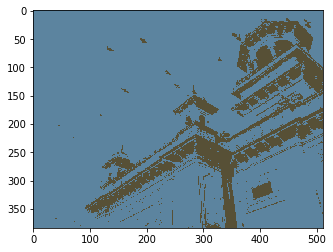

In [167]:
img_in = cv2.imread("home.jpg")
h, w, d = img_in.shape
img = img_in.reshape((h * w, d))

clusterProbs,clusterAvg = kMeans(img, 2)

clusterAvg = np.uint8(clusterAvg)
clusterProbs = np.uint8(clusterProbs)
output = clusterAvg[clusterProbs.flatten()]
output = output.reshape((img_in.shape))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

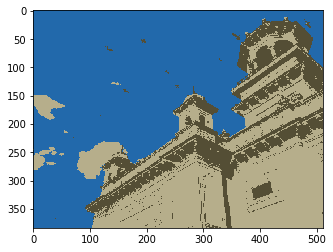

In [168]:
img_in = cv2.imread("home.jpg")
h, w, d = img_in.shape
img = img_in.reshape((h * w, d))

clusterProbs,clusterAvg = kMeans(img, 3)

clusterAvg = np.uint8(clusterAvg)
clusterProbs = np.uint8(clusterProbs)
output = clusterAvg[clusterProbs.flatten()]
output = output.reshape((img_in.shape))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

In [3]:
import numpy as np
import math
def multivariate_normal_fun(x, means, covs):
    size = len(means)
    if size == len(means) and (size, size) == covs.shape:
        det = np.linalg.det(covs)
        norm_const = 1/(((2*np.pi)**(size/2))*(det**(1/2)))
        x_m = x - means
        result = (-1/2) * (x_m.T.dot(np.linalg.inv(covs))).dot(x_m)
        return float(norm_const * np.exp(result))

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# from scipy.stats import multivariate_normal

def init(img, k):
    clusterProbs = np.random.rand(k)
    clusterProbs = clusterProbs / np.sum(clusterProbs)

#     c_x = np.random.rand(k)*100
#     c_y = np.random.rand(k)*100
#     c_z = np.random.rand(k)
#     clusterMeans = np.array(list(zip(c_x, c_y, c_z)), dtype=np.float32)

#     We could initialize to random cluster centers (means) but kmeans centers give better end results 
#     Uncomment the code aove and comment this one for random centers
    _, clusterMeans = kMeans(img, k)

    clusterCovariances = np.array([np.identity(3)*100] * k)

    return clusterProbs, clusterMeans, clusterCovariances

def expectation(img, clusterProbs, clusterMeans, clusterCovariences, k):
    n, d = img.shape

#   for each point find the probability that it belongs to each cluster
#   by multiplying the cluster's probability (initial assignment is random)
#   and the the multivariate Gaussian of the point
    pointProbsK = np.array([np.zeros(n)]*k)
    
#     uncomment this code to run the algorithm with the scipy library which runs faster and gives the same end result
#     for c in range(k):
#         multivariate_normal_ = multivariate_normal.pdf(img, clusterMeans[c], clusterCovariences[c])
#         pointProbsK[c] = clusterProbs[c]*multivariate_normal_
    
    for c in range(k):
        for i in range(img.shape[0]):
            multivariate_normal = multivariate_normal_fun(img[i], clusterMeans[c], clusterCovariences[c])
            pointProbsK[c][i] = clusterProbs[c]*multivariate_normal
    
    sum_pointProbsK = np.sum(pointProbsK, axis=0)
    pointProbsK = pointProbsK / sum_pointProbsK
    return pointProbsK

def maximization(img, pointProbsK, k):
    n, d = img.shape
    
#   for each cluster calculate the weight and probability of the cluster
#   by adding and averaging (in that order) the probability of each point belonging to the cluster
    totalWeightsPerCluster = np.sum(pointProbsK, axis=1)
    clusterProbs = totalWeightsPerCluster / n

    means = np.zeros((k, d))
# to calculate new means of the clusters sum all the possibilities of cluster c
    for i in range(k):
        means[i] = np.dot(pointProbsK[i], img) / totalWeightsPerCluster[i]

    covariances = np.array([np.identity(3)*100] * k)
    for i in range(k):
        diff = img - means[i]
        covariances[i] = np.dot(pointProbsK[i] * diff.T, diff) /  totalWeightsPerCluster[i]
    
    return clusterProbs, means, covariances

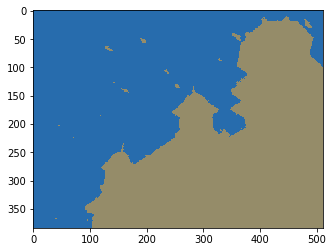

In [5]:
img_in = cv2.imread("home.jpg")
h, w, d = img_in.shape
img = img_in.reshape((h * w, d))

probsi, meansi, covi = init(img, 2)
probs = probsi
means = meansi
cov = covi

for i in range(10):
    pointProbsPerK = expectation(img, probs, means , cov, 2)
    probs, means, cov = maximization(img, pointProbsPerK, 2)

labels = np.argmax(pointProbsPerK, axis=0)

output = np.asarray(means[labels.reshape((h, w, 1))], dtype=np.uint8)
output = output.reshape(h,w,d)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()


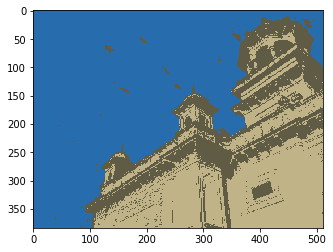

In [45]:
img_in = cv2.imread("home.jpg")
h, w, d = img_in.shape
img = img_in.reshape((h * w, d))

probs, means, cov = init(img, 3)
for i in range(10):
    pointProbsPerK = expectation(img, probs, means , cov, 3)
    probs, means, cov = maximization(img, pointProbsPerK, 3)

labels = np.argmax(pointProbsPerK, axis=0)

output = np.asarray(means[labels.reshape((h, w, 1))], dtype=np.uint8)
output = output.reshape(h,w,d)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()

Assuming we use the same initial centers for clusters if we choose a covariance of 0 for the EM algorithm and make sure we iterate fully at least once we will get the same results from EM and K_Means